# 🧭 Agentic RAG — Guided Exercise (Documentation + Try‑it tasks)

**Goal:** Keep the *existing code as-is* (including the question router) and layer clear explanations + short exercises so students can *understand and probe each stage*.

### Learning Outcomes
1. Understand how our **question router** chooses tools and why that matters.
2. See that the **retriever** already works as a stand‑alone component.
3. Run the **agent** end‑to‑end and interpret traces.
4. Compare simple parameter tweaks (`k`, chunk size) on retrieval quality.



## 0) Map of the Notebook
- **A. Build/Load Components**: embedding model, vector store (FAISS), retriever, tools.
- **B. Question Router**: routes user input to the right tool/agent path.
- **C. Agent Execution**: calls tools, synthesizes final answers.
- **D. (Optional) History**: can be added later — not required here.


## 🔩 Imports 

In [1]:
import os
from dotenv import load_dotenv
from PyPDF2 import PdfReader   # For reading PDF files
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.tools import create_retriever_tool
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import convert_to_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.vectorstores import FAISS


## 🔩 Load API Key

In [2]:
load_dotenv()
key = os.getenv("GOOGLE_API_KEY")

### 📄 Load a PDF & sanity-check the text

**What this does**
- Points to a PDF (`data/nihms-1901028.pdf`)
- Loads it with `PdfReader`
- Checks:
  - how many **pages** the PDF has
  - how many **characters** are extracted from **page 1**

In [3]:
pdf_path = "data/nihms-1901028.pdf"
reader = PdfReader(pdf_path)
print(len(reader.pages))
print(len(reader.pages[0].extract_text()))

18
2966


### 🧹 Collect all PDF text into one string

**What this does**
- Loops over all pages and calls `extract_text()`
- Skips pages that return `None`
- Joins everything into a single `text` string and prints it

**Why**
- Gives you one clean blob for chunking/embedding.

In [4]:
text = "".join(page.extract_text() for page in reader.pages if page.extract_text())
text

'High and normal protein diets improve body composition and \nglucose control in adults with type 2 diabetes: A randomized \ntrial\nJulianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. \nMcDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1\n1Department of Nutrition Sciences, University of Alabama at Birmingham\n2Department of Pediatrics, University of Colorado Anschutz Medical Campus\n3Department of Family and Community Medicine, University of Alabama at Birmingham\n4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, \nAurora, Colorado\n5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus\nAbstract\nObjective:\xa0 Weight loss of ≥10% improves glucose control and may remit type 2 diabetes \n(T2D). High protein (HP) diets are commonly used for weight loss, but whether protein \nsources, especially red meat, impact weight loss-induced T2D management is unknown. This 

### ✂️ Split text into chunks (token-aware)

**What this does**
- Uses a tokenizer-aware splitter to break `text` into overlapping chunks.
- Parameters:
  - `chunk_size=400` characters
  - `chunk_overlap=50` characters
- Stores the result in `chunks` and displays them.

**Why**
- Smaller, overlapping chunks can help to improve retrieval recall while keeping context.

In [5]:

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=400, chunk_overlap=50
)
chunks = text_splitter.split_text(text)
chunks[:2]

['High and normal protein diets improve body composition and \nglucose control in adults with type 2 diabetes: A randomized \ntrial\nJulianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. \nMcDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1\n1Department of Nutrition Sciences, University of Alabama at Birmingham\n2Department of Pediatrics, University of Colorado Anschutz Medical Campus\n3Department of Family and Community Medicine, University of Alabama at Birmingham\n4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, \nAurora, Colorado\n5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus\nAbstract\nObjective:\xa0 Weight loss of ≥10% improves glucose control and may remit type 2 diabetes \n(T2D). High protein (HP) diets are commonly used for weight loss, but whether protein \nsources, especially red meat, impact weight loss-induced T2D management is unknown. This

### 📦 Build a vector index with FAISS + Gemini embeddings

**What this does**
- Embeds each chunk using `GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")`
- Indexes vectors in **FAISS** (`from_texts`) for fast similarity search

In [6]:
vectorstore = FAISS.from_texts(chunks, embedding=GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001"))


E0000 00:00:1765458498.775319    8002 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


### 🔎 Try the index with different queries

*You can also change the value for k and see what happens*

In [9]:
query = "I'm newly diagnosed with type 2 diabetes. Is a higher-protein diet helpful?"
for document in vectorstore.similarity_search_with_score(query, k=4):
    print(document)

(Document(id='9a58317c-0fc4-41cd-8012-0c95c13eff6d', metadata={}, page_content='High and normal protein diets improve body composition and \nglucose control in adults with type 2 diabetes: A randomized \ntrial\nJulianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. \nMcDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1\n1Department of Nutrition Sciences, University of Alabama at Birmingham\n2Department of Pediatrics, University of Colorado Anschutz Medical Campus\n3Department of Family and Community Medicine, University of Alabama at Birmingham\n4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, \nAurora, Colorado\n5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus\nAbstract\nObjective:\xa0 Weight loss of ≥10% improves glucose control and may remit type 2 diabetes \n(T2D). High protein (HP) diets are commonly used for weight loss, but whether protein \nsources, e

Your turn — on-topic query (diabetes/protein)
Try a different wording or a specific sub-question (e.g., kidney disease, lean sources, satiety).

In [13]:
query = "I'm newly diagnosed with the suger disease. Is a higher-protein diet helpful?"
for document in vectorstore.similarity_search_with_score(query, k=4):
    print(document)

(Document(id='9a58317c-0fc4-41cd-8012-0c95c13eff6d', metadata={}, page_content='High and normal protein diets improve body composition and \nglucose control in adults with type 2 diabetes: A randomized \ntrial\nJulianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. \nMcDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1\n1Department of Nutrition Sciences, University of Alabama at Birmingham\n2Department of Pediatrics, University of Colorado Anschutz Medical Campus\n3Department of Family and Community Medicine, University of Alabama at Birmingham\n4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, \nAurora, Colorado\n5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus\nAbstract\nObjective:\xa0 Weight loss of ≥10% improves glucose control and may remit type 2 diabetes \n(T2D). High protein (HP) diets are commonly used for weight loss, but whether protein \nsources, e

Your turn — off-topic query (unrelated)
Ask something unrelated (e.g., “What’s the capital of France?”). Notice the retriever still returns something unless you add filters or thresholds.

In [14]:
query = "What’s the capital of France?"
for document in vectorstore.similarity_search_with_score(query, k=2):
    print(document)

(Document(id='d07e92c2-3717-401e-932a-3dc3358b7dfb', metadata={}, page_content='Primo, enCORE software version 15.10.046, GE Healthcare, Chicago, IL, USA). Waist \ncircumference (WC) was measured at the border of the iliac crest in duplicate in accordance \nwith the National Institutes of Health recommendations [ 32], measured at baseline and week \n52.\nCardiometabolic Health\nBlood samples were obtained at baseline and week 52 from an antecubital vein by a \ntrained phlebotomist. Samples were processed and analyzed for glucose, total cholesterol, \nlow‐density lipoprotein cholesterol (LDL; calculated), high ‐density lipoprotein cholesterol \n(HDL), triglycerides, HbA1c, and blood urea nitrogen (BUN). Blood samples were \nprocessed at the University of Alabama Outreach Lab for Alabama samples and at \nUniversity of Colorado Hospital Clinical Lab for screening and at the Adult CTRC Core lab \nfor baseline and week 52 visits for Colorado samples. Blood pressure was measured at each \nin

### 🔧 Turn the index into a retriever

**What this does**
- Wraps the FAISS index as a `retriever` you can call with natural-language queries.

**Default behavior**
- Returns top-k similar chunks

In [16]:
retriever = vectorstore.as_retriever()
retriever


VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7df49a84f1d0>, search_kwargs={})

### 🧰 Expose the retriever as a **Tool**

**What this does**
- Wraps your `retriever` as a tool the agent can call.
- `name="retrieve_medical_information"` → how the agent refers to it.
- `description=...` → guidance for when the tool should be used.

**Why**
- Tools make retrieval **addressable** by the agent/router (it can decide to call this when a query needs grounded info).

**Tip**
- Keep the tool name concise and the description specific (scope, domain). Clear wording improves routing.

In [17]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_medical_information",
    "Search and return information about Protein Diets for Daibetes 2 Patients.",
)

In [20]:
retriever_tool.invoke({"query": "types of protein diets"})

'High and normal protein diets improve body composition and \nglucose control in adults with type 2 diabetes: A randomized \ntrial\nJulianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. \nMcDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1\n1Department of Nutrition Sciences, University of Alabama at Birmingham\n2Department of Pediatrics, University of Colorado Anschutz Medical Campus\n3Department of Family and Community Medicine, University of Alabama at Birmingham\n4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, \nAurora, Colorado\n5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus\nAbstract\nObjective:\xa0 Weight loss of ≥10% improves glucose control and may remit type 2 diabetes \n(T2D). High protein (HP) diets are commonly used for weight loss, but whether protein \nsources, especially red meat, impact weight loss-induced T2D management is unknown. This 

### 🧠 Initialize the chat model (Gemini)

**What this does**
- Creates a Gemini chat model via `init_chat_model("google_genai:gemini-2.5-flash")`
- Sets `temperature=0` for factual, deterministic responses
- Uses your API key (`key`) to authenticate

**Why**
- This LLM will orchestrate the flow (decide when to call tools and synthesize answers).

In [21]:
response_model = init_chat_model("google_genai:gemini-2.5-flash", temperature=0, api_key=key)

E0000 00:00:1765459089.915052    8002 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


### 🧩 Agent step: let the model route (tool or direct answer)

**What this does**
- Defines `generate_query_or_respond(state: MessagesState)`.
- Binds the **retriever tool** to the Gemini model: `response_model.bind_tools([retriever_tool])`.
- Invokes the model on the current `state["messages"]`.
- Returns the new AI message to append to the conversation state.

**Why**
- The model now decides:  
  - **Call the tool** (retrieve context) **or**  
  - **Answer directly** (no retrieval)  
  This is the “question router” behavior.

In [22]:
def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

### 👋 Quick smoke test: model response

**What this does**
- Builds a minimal input state with one user message: `"hello!"`
- Runs `generate_query_or_respond(...)`
- Prints the **last** AI message with `pretty_print()`

In [23]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


### 🎭 Simulate a routed question (manual/fake input)

**What this does**
- Manually **constructs a state** with a user question about protein diets and T2D.
- Calls `generate_query_or_respond(...)` to let the model decide whether to **use the retriever tool** or answer directly.
- Prints the AI message.


- The reply may include or imply a **tool call** (retrieval) before the final answer.
- If it answers directly, try a more retrieval-worthy query (e.g., “List lean protein sources for T2D and explain why.”).

In [24]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What Protein diet is best for type 2 diabetes?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_medical_information (92241676-c2d7-401e-96e9-96218c44b689)
 Call ID: 92241676-c2d7-401e-96e9-96218c44b689
  Args:
    query: Protein diet for type 2 diabetes


### ✅ Define a simple relevance grader (schema)

**What this does**
- Creates a Pydantic model `GradeDocuments` with one field:  
  `binary_score ∈ {"yes","no"}` — “yes” if a chunk is relevant to the user’s question, otherwise “no”.

**Why**
- We’ll ask the LLM to grade each retrieved chunk using this schema, then **filter out** low-relevance hits before answering.

In [25]:
class GradeDocuments(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Relevance score: 'yes' if relevant, 'no' otherwise"
    )

### 🧪 Grade a retrieved chunk for relevance (route next step)

**What this does**
- Uses a **Gemini** grader (temperature=0) to judge if the latest retrieved **document chunk** is relevant to the **user question**.
- Parses the result with a **structured schema** (`GradeDocuments`) → `"yes"` or `"no"`.
- **Routes**:
  - `"yes"` → `generate_answer`
  - `"no"` → `rewrite_question` (we’ll try to reformulate the query)

**Inputs assumed from state**
- `question = state["messages"][0].content` (first user message)
- `context = state["messages"][-1].content` (most recent retrieved chunk)

grades one combined blob!

In [26]:
def grade_documents(state: MessagesState):
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    grader_model = init_chat_model("google_genai:gemini-2.5-flash", temperature=0, api_key=key)
    GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

### 🧪 Test the grader with a fake irrelevant result

**What this does**
- Manually builds a conversation state where:
  - User asks a protein/T2D question.
  - Assistant **requests** the retriever tool (simulated via `tool_calls`).
  - The tool **returns** an obviously irrelevant chunk: `"meow"`.

**Why**
- To verify the grader **rejects** irrelevant context and routes to `rewrite_question`.

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_medical_information",
                        "args": {"query": "Search and return information about Protein Diets for Daibetes 2 Patients."}
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

E0000 00:00:1765459453.469455    8002 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


'rewrite_question'

### 🧪 Test the grader with a fake **relevant** result and play around

**What this does**
- Simulates a conversation where the tool returns a relevant snippet:
  > “Diabetes 2 Patients can do high, medium or low protein diets.”
- Calls `grade_documents(...)` to decide the next route.

**Expect**
- The grader should return **`"generate_answer"`** (relevance = “yes”).

**Try**
- Tweak the tool text to be borderline (e.g., mention *protein* but not *diabetes*) and see if it still passes.
- Replace with a clearly off-topic line to confirm it flips back to **`"rewrite_question"`**.

In [34]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_medical_information",
                        "args": {"query": "Search and return information about Protein Diets for Diabetes 2 Patients."},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Diabetes 2 Patients can do high, medium or low protein diets.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

E0000 00:00:1765459582.127888    8002 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


'generate_answer'

### ✍️ Rewrite the question (when retrieval looks off)

**What this does**
- Takes the **original user question** and asks the model to **rephrase/improve** it.
- Returns a new **user** message with the reformulated question so the pipeline can try retrieval again.

**Why**
- If grading says the retrieved chunk is **not relevant**, a clearer query often fixes it
  (e.g., add keywords like “type 2 diabetes”, “protein sources”, “kidney disease”).

**Try**
- Feed a vague question (e.g., “What about protein?”)

In [35]:
def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question"
)
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

### 🧪 Test the rewriter

** If the rewriter returns more than one rewritten question:** Go back to the rewriter function and refine the prompt. We are still doing prompt engineering after all :)

In [39]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_medical_information",
                        "args": {"query": "Search and return information about Protein Diets for Diabetes 2 Patients."}
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

The original question "What Protein diet is best for type 2 diabetes?" is a bit vague and uses the absolute term "best," which can be misleading as dietary needs are highly individual, especially with a medical condition.

Here's an improved question that is more specific, comprehensive, and acknowledges individual factors:

**Improved Question:** "What are the recommended types and amounts of protein to include in a diet for managing type 2 diabetes, considering its impact on blood sugar control, satiety, and overall health, and how do individual needs influence these recommendations?"

**Reasoning for Improvement:**

1.  **Specificity:** Instead of "Protein diet," it asks about "recommended types and amounts of protein," which is much more actionable.
2.  **Acknowledges Goals:** It clarifies *why* protein is important by mentioning "impact on blood sugar control, satiety, and overall health."
3.  **Avoids Absolutes:** It replaces "best" with "recommended" and explicitly asks "how do 

### 🧾 Generate the final answer (using retrieved context)

**What this does**
- Builds a prompt that includes:
  - the **original question**
  - the **retrieved context** (last message)
- Calls the chat model to produce a **concise** answer (≤ 3 sentences).
- If the model can’t answer from the context, it should say **“I don’t know.”*

In [40]:

def generate_answer(state: MessagesState):
    """Generate an answer."""
    
    GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
    )

    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}



### 🧪 Fake a full pass → generate an answer

**What this does**
- Simulates a tool return (context) and asks the model to answer:
  ```python
  response = generate_answer(input)
  response["messages"][-1].pretty_print()

**Try (on-topic)**

-Change the user question or the tool context:

`“List lean protein sources for T2D and explain why.”`

`“How does kidney disease affect protein targets in T2D?”`

**Try (edge/off-topic)**

Ask something unrelated (capital of a country) and see if the model says “I don’t know” with the given context.

In [41]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_medical_information",
                        "args": {"query": "Search and return information about Protein Diets for Diabetes 2 Patients."},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "There are high, medium and low protein diets and none of them is evidently much better than the other.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

According to the provided context, no single protein diet, whether high, medium, or low, is evidently much better than the others for type 2 diabetes.


### 🕸️ Assemble the LangGraph workflow

**What this builds**
- A small graph that routes between **LLM** and **tool**, then **grades** the result and either **answers** or **rewrites** the question.

**Nodes**
- `generate_query_or_respond` → Model decides: call tool or answer directly
- `retrieve` → Executes the retriever tool (`ToolNode([retriever_tool])`)
- `grade_documents` → Checks if retrieved context is relevant
- `rewrite_question` → Improves the query if context is off-topic
- `generate_answer` → Writes the final, concise answer

**Edges & logic**
1. `START → generate_query_or_respond`
2. `generate_query_or_respond ──tools_condition──▶ retrieve`  
   `generate_query_or_respond ──(no tool)──▶ END`
3. `retrieve ──grade_documents──▶ generate_answer` *(if relevant)*  
   `retrieve ──grade_documents──▶ rewrite_question` *(if not relevant)*
4. `rewrite_question ──▶ generate_query_or_respond` (try again)
5. `generate_answer ──▶ END`

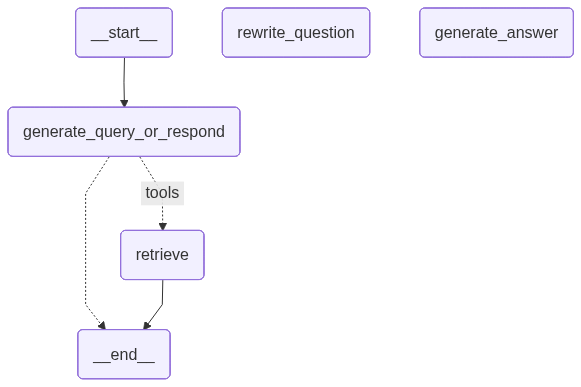

In [43]:
workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile

graph = workflow.compile()
graph


### ▶️ First run: stream the graph step-by-step

**What this does**
- Executes the graph **once** and streams each node’s update:
  - `generate_query_or_respond` → decides whether to call the tool
  - `retrieve` → returns snippets from the vector store (if called)
  - `grade_documents` → checks relevance and routes next
  - `rewrite_question` → improves the query (if needed)
  - `generate_answer` → final concise answer

**Why**
- Lets you **see the full decision flow** (router → retrieve → grade → answer/rewrite).

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_medical_information (14db8ce0-2d77-448f-aa38-83c3bab52083)
 Call ID: 14db8ce0-2d77-448f-aa38-83c3bab52083
  Args:
    query: Protein diet for type 2 diabetes





E0000 00:00:1765460178.630794    8002 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Update from node retrieve
================================= Tool Message =================================
Name: retrieve_medical_information

High and normal protein diets improve body composition and 
glucose control in adults with type 2 diabetes: A randomized 
trial
Julianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. 
McDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1
1Department of Nutrition Sciences, University of Alabama at Birmingham
2Department of Pediatrics, University of Colorado Anschutz Medical Campus
3Department of Family and Community Medicine, University of Alabama at Birmingham
4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, 
Aurora, Colorado
5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus
Abstract
Objective:  Weight loss of ≥10% improves glucose control and may remit type 2 diabetes 
(T2D). High protein (HP) diets are commonly used fo

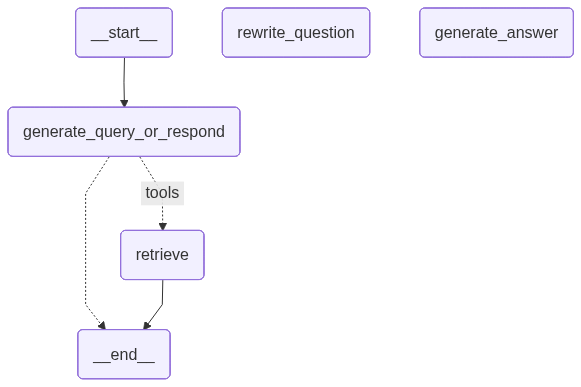

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

### 🧩 `run_agent(question: str) -> str` — simple, frontend-ready entrypoint

**What it does**
- Takes a user question (string)
- Runs the **LangGraph agent** end-to-end (no streaming)
- Returns the final assistant **answer text** only

**Why**
- Hides orchestration complexity → easy to plug into a web/API frontend.


In [51]:
def run_agent(question: str) -> str:
    """
    Minimal, frontend-ready wrapper.
    Takes a user question, runs the LangGraph agent, and returns the final answer text.
    """
    # Build the LangGraph input
    state_in = {"messages": [{"role": "user", "content": "what is the best protien source?"}]}

    # Run to completion (no streaming)
    state_out = graph.invoke(state_in)

    # Extract the final assistant message content robustly
    messages = state_out.get("messages", [])
    if not messages:
        return ""

    last = messages[-1]
    # Handle both LC message objects and plain dicts
    content = getattr(last, "content", None)
    if content is None and isinstance(last, dict):
        content = last.get("content", "")

    return content or ""

In [52]:
print(run_agent("What protein diet is best for type 2 diabetes?"))

E0000 00:00:1765461587.548753    8002 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Based on the provided context, there is no single "best" protein source identified. The text discusses higher protein diets in general for weight loss and body composition. It also mentions red meats, including beef, as significant protein contributors, noting conflicting findings regarding their health effects. Lean pork, chicken, and fish are also mentioned as protein sources in the context of a DASH diet.
